**Manuscript preparation**

The notebook provides summary statements regarding the data used for testing C2S2 clustering algorithm.

# Read the datasets

In [1]:
import os
import typing

import hpotk as ht
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ddconst.plotting.colors as c

figargs = {'figsize': (6, 4), 'dpi': 120}

## Gather paths to phenopackets per gene

Get paths to phenopackets per gene. `base_dir` must be a folder with folders named with HGVS gene symbols.

In [2]:
from collections import defaultdict

gene2pp_fpath = defaultdict(list)

base_dir = os.path.abspath(os.path.join('..', 'phenopackets'))

print(f'Reading files in {base_dir}')

for gene_dir in os.listdir(base_dir):
    fpath_gene = os.path.join(base_dir, gene_dir)
    if os.path.isdir(fpath_gene):
        for fname in os.listdir(fpath_gene):
            fpath_pp = os.path.join(fpath_gene, fname)
            if os.path.isfile(fpath_pp) and fpath_pp.endswith('.json'):
                gene2pp_fpath[gene_dir].append(fpath_pp)
            else:
                print(f'Skipping {fpath_pp}, not a file that ends with `.json`')
    else:
        print(f'Skipping {fpath_gene}, not a directory')

print(f'Found {len(gene2pp_fpath)} genes: {list(sorted(gene2pp_fpath.keys()))}')

Reading files in /home/ielis/ielis/phenotypes/c2s2-clin/phenopackets
Found 8 genes: ['COL3A1', 'LMNA', 'OFD1', 'SLC4A1', 'SMARCB1', 'SON', 'WFS1', 'WWOX']


## Read phenopackets into C2S2 samples

In [3]:
from c2s2.base.model import Sample, PhenotypicFeature
from c2s2.standard.bench import read_phenopacket, BenchSample, DiseaseIdentifier

gene2sample = defaultdict(list)

for gene_symbol, fpaths_pp in gene2pp_fpath.items():
    for fpath_pp in fpaths_pp:
        sample: BenchSample = read_phenopacket(fpath_pp, include_excluded=True)  # We definitely want to include the excluded features
        gene2sample[gene_symbol].append((fpath_pp, sample))

## Load samples into a data frame

Let's create a data frame to simplify calculation of summary statistics.

In [4]:
data = defaultdict(list)

for gene_symbol, samples in gene2sample.items():
    for fpath_pp, sample in samples:
        for pf in sample.phenotypic_features:
            basename = os.path.basename(fpath_pp).replace('.json', '')
            data['basename'].append(basename)
            data['gene_symbol'].append(gene_symbol)
            data['disease_id'].append(sample.disease_identifier.identifier.value)
            data['sample_id'].append(sample.label)
            data['phenotype_id'].append(pf.identifier.value)
            data['phenotype_status'].append(pf.is_present)

samples = pd.DataFrame(data=data).set_index(['gene_symbol', 'disease_id', 'sample_id']).sort_index()
samples.head(2)

basename phenotype_id  \
gene_symbol disease_id  sample_id                                 
COL3A1      OMIM:130050 1          PMID_15007000_1   HP:0000978   
                        1          PMID_15007000_1   HP:0010648   

                                   phenotype_status  
gene_symbol disease_id  sample_id                    
COL3A1      OMIM:130050 1                      True  
                        1                      True

# Manuscript

## Results

### A dataset of genes associated with multiple disease entities

In [5]:
n_genes = len(samples.index.levels[0])
print(f'We created a dataset of case reports for {n_genes} genes associated with multiple Mendelian disease entities.')

We created a dataset of case reports for 8 genes associated with multiple Mendelian disease entities.


In [6]:
cases_per_gene = samples.groupby('gene_symbol')['basename'].nunique()
print(f'In total, we collected {cases_per_gene.sum()} case reports (mean {cases_per_gene.mean():.2f} ±{cases_per_gene.std():.2f} per gene).')

In total, we collected 217 case reports (mean 27.12 ±14.54 per gene).


In [7]:
pf_by_status = samples.groupby('phenotype_status').size()
print(f'The cohorts included {pf_by_status.sum()} HPO terms ({pf_by_status[True]} present, {pf_by_status[False]} excluded).')

The cohorts included 3977 HPO terms (2206 present, 1771 excluded).


In [8]:
pf_cnts = []
for gene_symbol in samples.index.levels[0]:
    data = samples.loc[gene_symbol]
    sample_names = data['basename'].unique()
    idx = pd.MultiIndex.from_product(iterables=[sample_names, (True, False)], 
                                     names=['basename', 'phenotype_status'])
    pf_cnt = data.groupby(['basename', 'phenotype_status']).size().reindex(idx, fill_value=0)
    pf_cnt.name = 'pf_count'
    pf_cnt = pf_cnt.reset_index()
    pf_cnt['gene_symbol'] = gene_symbol
    pf_cnts.append(pf_cnt)

n_terms_per_sample = pd.concat(pf_cnts).set_index(['gene_symbol', 'basename', 'phenotype_status']).sort_index()
n_terms_per_sample.head(2)

pf_count
gene_symbol basename        phenotype_status          
COL3A1      PMID_15007000_1 False                    0
                            True                     4

Box plot with counts of observed and excluded phenotypic features per sample.

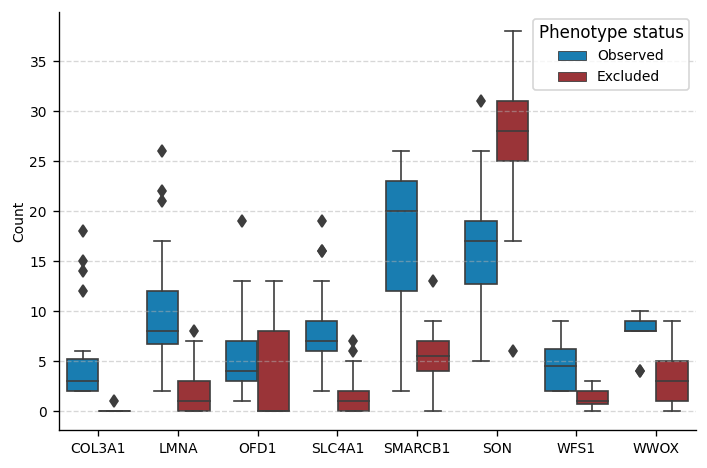

In [9]:
data = n_terms_per_sample.reset_index()
fig, ax = plt.subplots(**figargs)
sns.boxplot(data=data, x='gene_symbol', y='pf_count', hue='phenotype_status', 
            hue_order=(True, False), linewidth=1., palette=[c.blue_light, c.red], 
            ax=ax)
ax.set(xlabel=None, ylabel='Count')
ax.legend_.set(title='Phenotype status')
ax.legend_.texts[0].set_text('Observed')
ax.legend_.texts[1].set_text('Excluded')
ax.grid(axis='y')
fig.tight_layout()

In [10]:
# Ensure our counts are correct
n_pos_terms_per_sample = n_terms_per_sample.loc[:, :, True]
assert pf_by_status[True] == n_pos_terms_per_sample.sum()[0]

n_exc_terms_per_sample = n_terms_per_sample.loc[:, :, False]
assert pf_by_status[False] == n_exc_terms_per_sample.sum()[0]

print(f'On average, the subjects were annotated with {n_pos_terms_per_sample.mean()[0]:.0f}±{n_pos_terms_per_sample.std()[0]:.0f} observed HPO terms '
f'and {n_exc_terms_per_sample.mean()[0]:.0f}±{n_exc_terms_per_sample.std()[0]:.0f} excluded HPO terms.')

On average, the subjects were annotated with 10±7 observed HPO terms and 8±11 excluded HPO terms.


In [11]:
# This may need to be fixed - to remove the *SON* variant?
n_disease_entities = samples.reset_index().groupby(['gene_symbol'])['disease_id'].nunique()
f'The number of diseases associated with genes ranged between [{n_disease_entities.min()}, {n_disease_entities.max()}]'

'The number of diseases associated with genes ranged between [1, 5]'